In [ ]:
import dataclasses
import pathlib

import cv2
import numpy as np
import PIL.Image
import rosbag
import torch
import tqdm
import yaml

In [ ]:
from rpg_e2vid.utils.inference_utils import events_to_voxel_grid
from rpg_e2vid.utils.loading_utils import load_model

import utils

In [ ]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [ ]:
BAG_PATH = pathlib.Path("../data/raw/vivid/city_day1_small.bag")
# topic_name = "/camera/image_color"
topic_name = "/dvs/events"
bag = rosbag.Bag(BAG_PATH)

In [ ]:
def event_array_to_numpy(events) -> np.ndarray:
    return np.array(
        [
            [event.ts.to_nsec() // 1_000_000, event.x, event.y, event.polarity]
            for event in events
        ]
    )

In [ ]:
events_file = pathlib.Path("../data/raw/vivid/events.npy")
if events_file.exists():
    events = np.load(events_file)
else:
    num_events = []
    events = []
    n_event_msgs = bag.get_message_count(topic_filters=[topic_name])
    for topics, msg, t in tqdm.tqdm(
        bag.read_messages(topics=[topic_name]), total=n_event_msgs
    ):
        ts_milis = msg.header.stamp.to_nsec() / 1e6
        msg_ts_milis = t.to_nsec() / 1e6
        window = event_array_to_numpy(msg.events)
        events.append(window)

    events = np.concatenate(events)

In [ ]:
_, ts_counts = np.unique(events[:, 0], return_counts=True)

In [ ]:
img_topic_name = "/camera/image_color"
imgs = []
img_ts = []
n_img_msgs = bag.get_message_count(topic_filters=[img_topic_name])
for topics, msg, t in tqdm.tqdm(
    bag.read_messages(topics=[img_topic_name]), total=n_img_msgs
):
    img = np.frombuffer(msg.data, dtype=np.uint8).reshape(msg.height, msg.width, 3)
    img_ts.append(msg.header.stamp.to_nsec() / 1e6)
    imgs.append(img)

imgs = np.stack(imgs)
img_ts = np.array(img_ts)

100%|██████████| 200/200 [00:00<00:00, 201.32it/s]


In [ ]:
model = load_model("../pretrained/E2VID_lightweight.pth.tar")

c:\Users\njytwf\AppData\Local\anaconda3\envs\masters\lib\site-packages\rpg_e2vid\utils\loading_utils.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_model = torch.lo

Using TransposedConvLayer (fast, with checkerboard artefacts)


In [ ]:
eit = utils.EventWindowIterator(events, ts_counts, 30, 30, 0)
prev = None
rec_frames = []
rec_ts = []
for (
    i,
    window,
) in tqdm.tqdm(enumerate(eit), total=len(eit)):
    rec_ts.append(window[-1, 0])
    window = window.copy()
    vg = events_to_voxel_grid(window, 5, 640, 480)
    vg = torch.from_numpy(vg).unsqueeze(0).float()  # .to(const.DEVICE)
    with torch.no_grad():
        pred, prev = model(vg, prev)
        pred = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
    rec_frames.append(pred)

rec_ts = np.array(rec_ts)
rec_frames = np.stack(rec_frames)

100%|██████████| 333/333 [02:22<00:00,  2.34it/s]


In [ ]:
# match rec_ts index to img_ts index
rec_idx = np.searchsorted(rec_ts, img_ts)
img_idx = np.searchsorted(img_ts, rec_ts)

In [ ]:
@dataclasses.dataclass
class CalibrationParams:
    K0: np.ndarray
    dist0: np.ndarray
    K1: np.ndarray
    dist1: np.ndarray
    T: np.ndarray

    def __post_init__(self):
        self.K0 = np.array(
            [[self.K0[0], 0, self.K0[2]], [0, self.K0[1], self.K0[3]], [0, 0, 1]]
        )
        self.K1 = np.array(
            [[self.K1[0], 0, self.K1[2]], [0, self.K1[1], self.K1[3]], [0, 0, 1]]
        )

    @property
    def R(self):
        return self.T[:3, :3]

    @property
    def t(self):
        return self.T[:3, 3].reshape(3, 1)

    @classmethod
    def from_yaml(cls, path: pathlib.Path):
        with open(path) as f:
            data = yaml.safe_load(f)
        return cls(
            K0=np.array(data["cam0"]["intrinsics"]),
            dist0=np.array(data["cam0"]["distortion_coeffs"]),
            K1=np.array(data["cam1"]["intrinsics"]),
            dist1=np.array(data["cam1"]["distortion_coeffs"]),
            T=np.array(data["cam1"]["T_cn_cnm1"]),
        )


calib = CalibrationParams.from_yaml(pathlib.Path("../data/raw/vivid/calib.yaml"))

In [ ]:
sampled_rec_idx = 100
sampled_img_idx = rec_idx[sampled_rec_idx] - 60
sampled_img = imgs[sampled_img_idx]
sampled_rec = rec_frames[sampled_rec_idx]

In [ ]:
sampled_img_undist = cv2.fisheye.undistortImage(
    sampled_img, calib.K0, calib.dist0, Knew=calib.K0
)
sampled_rec_undist = cv2.undistort(sampled_rec, calib.K1, calib.dist1)

h_rgb, w_rgb = sampled_img_undist.shape[:2]
h_rec, w_rec = sampled_rec_undist.shape[:2]

u, v = np.meshgrid(np.arange(w_rgb), np.arange(h_rgb))
u = u.astype(np.float32)
v = v.astype(np.float32)

x_norm = (u - calib.K0[0, 2]) / calib.K0[0, 0]
y_norm = (v - calib.K0[1, 2]) / calib.K0[1, 1]
points_cam0 = np.stack([x_norm, y_norm, np.ones_like(x_norm)], axis=-1)
points_cam0 = points_cam0.reshape(-1, 3).T

points_cam1 = calib.R @ points_cam0 + calib.t
points_cam1_norm = points_cam1 / points_cam1[2, :]
u1 = (calib.K1[0, 0] * points_cam1_norm[0, :]) + calib.K1[0, 2]
v1 = (calib.K1[1, 1] * points_cam1_norm[1, :]) + calib.K1[1, 2]

map_x = u1.reshape(h_rgb, w_rgb).astype(np.float32)
map_y = v1.reshape(h_rgb, w_rgb).astype(np.float32)

sampled_img_warped = cv2.remap(sampled_img_undist, map_x, map_y, cv2.INTER_LINEAR)
sampled_img_warped = sampled_img_warped[-h_rec:, -w_rec - 20 : -20]
sampled_rec_undist = np.repeat(sampled_rec_undist[:, :, None], 3, axis=-1)

(480, 640, 3) (480, 640, 3)


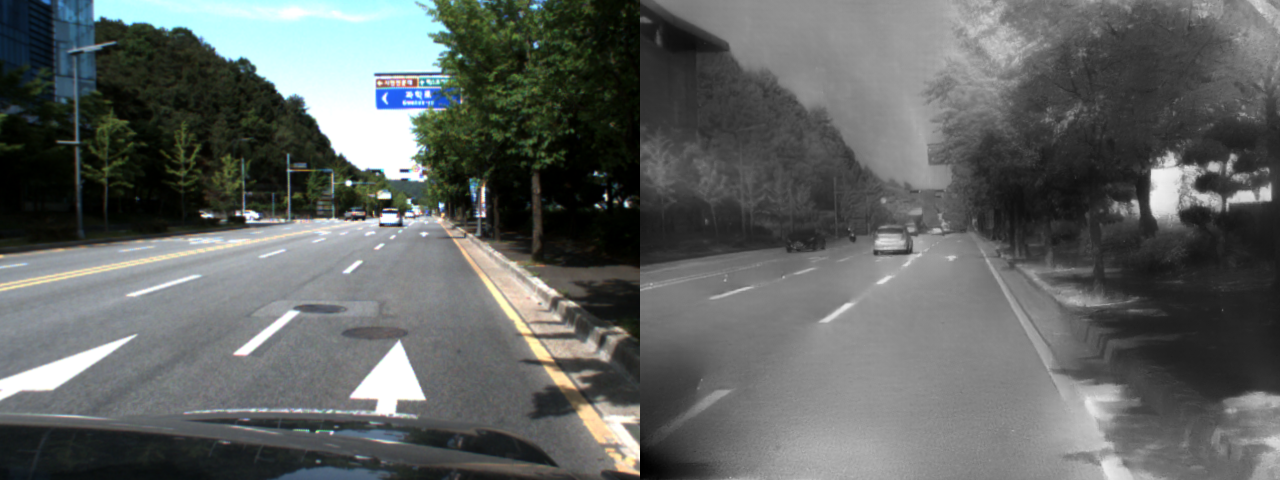

In [ ]:
# combine half with half horizontally
print(sampled_img_warped.shape, sampled_rec_undist.shape)
combined = np.hstack([sampled_img_warped, sampled_rec_undist])

# showarray(sampled_img_warped)
# showarray(sampled_rec_undist)
showarray(combined)